# The Perceptron algorithm at work

## 1. The algorithm

In [5]:
def evaluate_classifier(w,b,x):
    if (np.dot(w,x) + b) > 0:
        return 1
    if (np.dot(w,x) + b) < 0:
        return -1
    return 0

In [6]:
def train_perceptron(x,y,n_iters=100):
    n,d = x.shape
    w = np.zeros(d)
    b = 0
    done = False
    converged = True
    iters = 0
    np.random.seed(None)
    while not(done):
        done = True
        I = np.random.permutation(n)
        for i in range(n):
            j = I[i]
            if (evaluate_classifier(w,b,x[j,:]) != y[j]):
                w = w + y[j] * x[j,:]
                b = b + y[j]
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    if converged:
        print ("Perceptron algorithm: iterations until convergence: ", iters)
    else:
        print ("Perceptron algorithm: did not converge within the specified number of iterations")
    return w, b, converged

## 2. Experiments with the Perceptron

In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [7]:
def run_perceptron(datafile):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Run the Perceptron algorithm for at most 100 iterations
    w,b,converged = train_perceptron(x,y,100)
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points
    plt.plot(x[(y==1),0], x[(y==1),1], 'ro')
    plt.plot(x[(y==-1),0], x[(y==-1),1], 'k^')
    # Construct a grid of points at which to evaluate the classifier
    if converged:
        grid_spacing = 0.05
        xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = np.array([evaluate_classifier(w,b,pt) for pt in grid])
        # Show the classifier's boundary using a color plot
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.PRGn, vmin=-3, vmax=3)
    plt.show()

Perceptron algorithm: iterations until convergence:  5


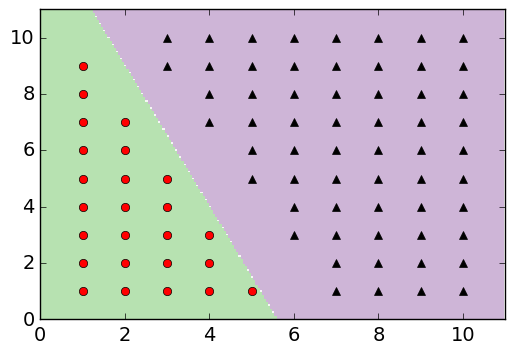

In [8]:
run_perceptron('C:/Users/tp179902741/Documents/Machine_learning/perceptron_at_work/data_1.txt')

Perceptron algorithm: did not converge within the specified number of iterations


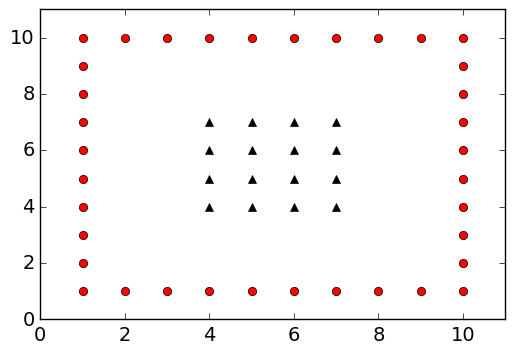

In [9]:
run_perceptron('C:/Users/tp179902741/Documents/Machine_learning/perceptron_at_work/data_2.txt')

# Sentiment analysis with support vector machines

## 1. Loading and preprocessing the data

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

## Read in the data set.
with open("C:/Users/tp179902741/Documents/Machine_learning/sentiment-logistic-regression/sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
data_mat = data_features.toarray()

## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Fitting a support vector machine to the data

In [3]:
from sklearn import svm
def fit_classifier(C_value=1.0):
    clf = svm.LinearSVC(C=C_value, loss='hinge')
    clf.fit(train_data,train_labels)
    ## Get predictions on training data
    train_preds = clf.predict(train_data)
    train_error = float(np.sum((train_preds > 0.0) != (train_labels > 0.0)))/len(train_labels)
    ## Get predictions on test data
    test_preds = clf.predict(test_data)
    test_error = float(np.sum((test_preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
    ##
    return train_error, test_error

In [4]:
cvals = [0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
for c in cvals:
    train_error, test_error = fit_classifier(c)
    print ("Error rate for C = %0.2f: train %0.3f test %0.3f" % (c, train_error, test_error))

Error rate for C = 0.01: train 0.216 test 0.250
Error rate for C = 0.10: train 0.074 test 0.174
Error rate for C = 1.00: train 0.011 test 0.152
Error rate for C = 10.00: train 0.002 test 0.188
Error rate for C = 100.00: train 0.002 test 0.196
Error rate for C = 1000.00: train 0.004 test 0.214
Error rate for C = 10000.00: train 0.001 test 0.208


## 3. Evaluating C by k-fold cross-validation

In [5]:
def cross_validation_error(x,y,C_value,k):
    n = len(y)
    ## Randomly shuffle indices
    indices = np.random.permutation(n)
    
    ## Initialize error
    err = 0.0
    
    ## Iterate over partitions
    for i in range(k):
        ## Partition indices
        test_indices = indices[int(i*(n/k)):int((i+1)*(n/k) - 1)]
        train_indices = np.setdiff1d(indices, test_indices)
        
        ## Train classifier with parameter c
        clf = svm.LinearSVC(C=C_value, loss='hinge')
        clf.fit(x[train_indices], y[train_indices])
        
        ## Get predictions on test partition
        preds = clf.predict(x[test_indices])
        
        ## Compute error
        err += float(np.sum((preds > 0.0) != (y[test_indices] > 0.0)))/len(test_indices)
        
    return err/k

## 4. Picking a value of C

In [19]:
def choose_parameter(x,y,k):
    
    errlist = []
    cvals = [0.1,0.13,0.2,0.23,0.3,0.33,0.4,0.5]
    for c in cvals:
        errlist += [cross_validation_error(x,y,c,k)]
    
    #display
    x = np.log10(cvals)
#     x1min = min(x) - 1
#     x1max = max(x) + 1
#     x2min = min(y) - 0.001
#     x2max = max(y) + 0.001
#     plt.xlim(x1min,x1max)
#     plt.ylim(x2min,x2max)
    plt.plot(x, errlist, 'ro')
    
    #return
    c = cvals[np.argmin(errlist)]
    err = min(errlist)
    return c, err

Choice of C:  0.13
Cross-validation error estimate:  0.18674698795180722
Test error:  0.154


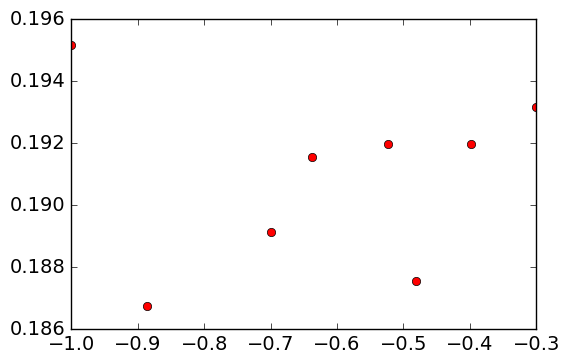

In [20]:
c, err = choose_parameter(train_data, train_labels, 10)
print("Choice of C: ", c)
print("Cross-validation error estimate: ", err)
## Train it and test it
clf = svm.LinearSVC(C=c, loss='hinge')
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)
error = float(np.sum((preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
print("Test error: ", error)

# Multiclass Perceptron and SVM

## 1. Multiclass Perceptron

In [1]:
def evaluate_classifier(w,b,x):
    k = len(b)
    scores = np.zeros(k)
    for j in range(k):
        scores[j] = np.dot(w[j,:],x) + b[j]
    return int(np.argmax(scores))

In [2]:
def train_multiclass_perceptron(x,y,k,n_iters=100):
    n,d = x.shape
    w = np.zeros((k,d))
    b = np.zeros(k)
    done = False
    converged = True
    iters = 0
    np.random.seed(None)
    while not(done):
        done = True
        I = np.random.permutation(n)
        for j in I:
            pred_y = evaluate_classifier(w,b,x[j,:])
            true_y = int(y[j])
            if pred_y != true_y:
                w[true_y,:] = w[true_y,:] + x[j,:]
                b[true_y] = b[true_y] + 1.0
                w[pred_y,:] = w[pred_y,:] - x[j,:]
                b[pred_y] = b[pred_y] - 1.0
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    if converged:
        print ("Perceptron algorithm: iterations until convergence: ", iters)
    else:
        print ("Perceptron algorithm: did not converge within the specified number of iterations")
    return w, b, converged

## 2. Experiments with multiclass Perceptron

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [4]:
def display_data_and_boundary(x,y,pred_fn):
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points
    k = int(max(y)) + 1
    cols = ['ro', 'k^', 'b*','gx']
    for label in range(k):
        plt.plot(x[(y==label),0], x[(y==label),1], cols[label%4], markersize=8)
    # Construct a grid of points at which to evaluate the classifier
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = np.array([pred_fn(pt) for pt in grid])
    # Show the classifier's boundary using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.Pastel1, vmin=0, vmax=k)
    plt.show()

In [5]:
def run_multiclass_perceptron(datafile):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    k = int(max(y)) + 1
    print ("Number of classes: ", k)
    # Run the Perceptron algorithm for at most 1000 iterations
    w,b,converged = train_multiclass_perceptron(x,y,k,1000)
    # Show the data and boundary
    pred_fn = lambda p: evaluate_classifier(w,b,p)
    display_data_and_boundary(x,y,pred_fn)

Number of classes:  4
Perceptron algorithm: iterations until convergence:  28


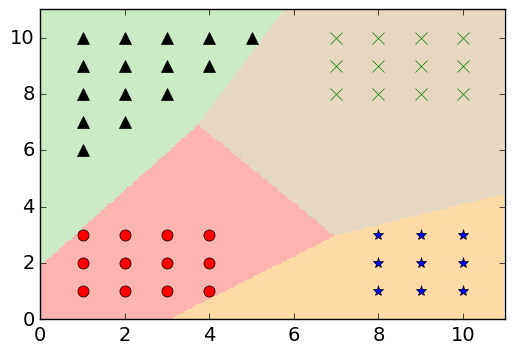

In [7]:
run_multiclass_perceptron('C:/Users/tp179902741/Documents/Machine_learning/multiclass/data_3.txt')

Number of classes:  3
Perceptron algorithm: iterations until convergence:  46


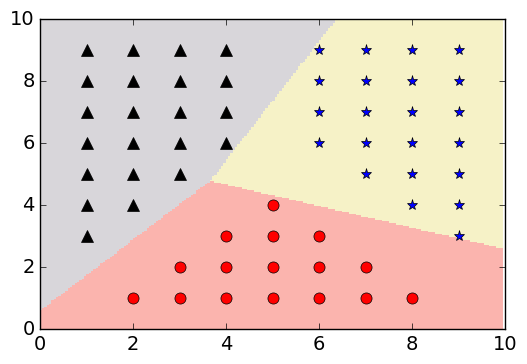

In [8]:
run_multiclass_perceptron('C:/Users/tp179902741/Documents/Machine_learning/multiclass/data_4.txt')

## 3. Experiments with multiclass SVM

In [9]:
from sklearn.svm import SVC, LinearSVC
def run_multiclass_svm(datafile,C_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    k = int(max(y)) + 1
    print ("Number of classes: ", k)
    # Train an SVM
    clf = LinearSVC(loss='hinge', multi_class='crammer_singer', C=C_value)
    clf.fit(x,y)
    # Show the data and boundary
    pred_fn = lambda p: clf.predict(p.reshape(1,-1))    
    display_data_and_boundary(x,y,pred_fn)

Number of classes:  4


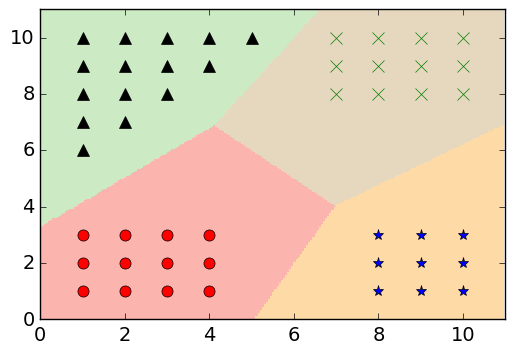

In [10]:
run_multiclass_svm('C:/Users/tp179902741/Documents/Machine_learning/multiclass/data_3.txt',10.0)

Number of classes:  3


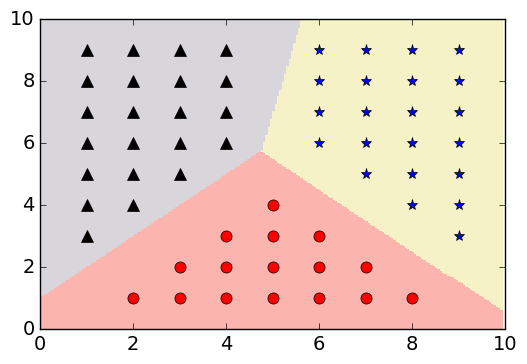

In [11]:
run_multiclass_svm('C:/Users/tp179902741/Documents/Machine_learning/multiclass/data_4.txt',100.0)